<a href="https://colab.research.google.com/github/harshita0147/Harshita_Pamu_INFO5731_Fall2024/blob/main/INFO5731_Exercise_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 5**

**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## **Question 1 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


**Algorithms:**

*   MultinominalNB
*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

**Evaluation measurement:**


*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np

# *1. Load and Parse Training Data*
def load_and_parse(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['raw'])
    data[['label', 'text']] = data['raw'].str.split(' ', n=1, expand=True)
    data.drop(columns=['raw'], inplace=True)
    data['label'] = data['label'].astype(int)
    data.dropna(subset=['label', 'text'], inplace=True)
    return data

train_data = load_and_parse('stsa-train.txt')
test_data = load_and_parse('stsa-test.txt')

print("Sample Training Data:")
print(train_data.head())

# *2. Split Training Data into Train and Validation Sets*
X = train_data['text']
y = train_data['label']

test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# *3. MultinomialNB with CountVectorizer*
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_val_vect = vectorizer.transform(X_val)
X_test_vect = vectorizer.transform(test_data['text'])

# Handle class imbalance for CountVectorizer
ros = RandomOverSampler(random_state=42)
X_train_vect_resampled, y_train_vect_resampled = ros.fit_resample(X_train_vect, y_train)

# Train MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vect_resampled, y_train_vect_resampled)

# *4. Tokenize Text for Word2Vec*
X_train_tokens = [sentence.split() for sentence in X_train]
X_val_tokens = [sentence.split() for sentence in X_val]
X_test_tokens = [sentence.split() for sentence in test_data['text']]

# *5. Train Word2Vec Model*
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=42)

# Compute Word2Vec embeddings
def compute_average_w2v(tokens, w2v_model):
    return np.array([
        np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(100)], axis=0)
        for sentence in tokens
    ])

X_train_w2v = compute_average_w2v(X_train_tokens, w2v_model)
X_val_w2v = compute_average_w2v(X_val_tokens, w2v_model)
X_test_w2v = compute_average_w2v(X_test_tokens, w2v_model)

# Handle class imbalance for Word2Vec embeddings
X_train_w2v_resampled, y_train_w2v_resampled = ros.fit_resample(X_train_w2v, y_train)

# *6. Train Models on Word2Vec*
# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_w2v_resampled, y_train_w2v_resampled)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_w2v_resampled, y_train_w2v_resampled)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_w2v_resampled, y_train_w2v_resampled)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_w2v_resampled, y_train_w2v_resampled)

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_w2v_resampled, y_train_w2v_resampled)

# *7. Evaluation Function*
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='binary', zero_division=0)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)

    return {
        "Validation": {
            "Accuracy": val_accuracy,
            "Precision": val_precision,
            "Recall": val_recall,
            "F1 Score": val_f1,
        },
        "Test": {
            "Accuracy": test_accuracy,
            "Precision": test_precision,
            "Recall": test_recall,
            "F1 Score": test_f1,
        }
    }

# *8. Evaluate Models*
# MultinomialNB
nb_results = evaluate_model(nb_model, X_val_vect, y_val, X_test_vect, test_data['label'])
print("\n### MultinomialNB Results ###")
print("Validation Metrics:")
for metric, value in nb_results["Validation"].items():
    print(f"{metric}: {value:.4f}")
print("\nTest Metrics:")
for metric, value in nb_results["Test"].items():
    print(f"{metric}: {value:.4f}")

# Other models using Word2Vec
models = {
    "SVM": svm_model,
    "KNN": knn_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
}

for model_name, model in models.items():
    results = evaluate_model(model, X_val_w2v, y_val, X_test_w2v, test_data['label'])
    print(f"\n### {model_name} Results ###")
    print("Validation Metrics:")
    for metric, value in results["Validation"].items():
        print(f"{metric}: {value:.4f}")
    print("\nTest Metrics:")
    for metric, value in results["Test"].items():
        print(f"{metric}: {value:.4f}")

Sample Training Data:
   label                                               text
0      1  a stirring , funny and finally transporting re...
1      0  apparently reassembled from the cutting-room f...
2      0  they presume their audience wo n't sit still f...
3      1  this is a visually stunning rumination on love...
4      1  jonathan parker 's bartleby should have been t...

### MultinomialNB Results ###
Validation Metrics:
Accuracy: 0.7854
Precision: 0.7899
Recall: 0.8019
F1 Score: 0.7959

Test Metrics:
Accuracy: 0.8089
Precision: 0.8066
Recall: 0.8119
F1 Score: 0.8092

### SVM Results ###
Validation Metrics:
Accuracy: 0.5672
Precision: 0.5662
Recall: 0.7285
F1 Score: 0.6372

Test Metrics:
Accuracy: 0.5783
Precision: 0.5562
Recall: 0.7679
F1 Score: 0.6451

### KNN Results ###
Validation Metrics:
Accuracy: 0.5101
Precision: 0.5292
Recall: 0.5526
F1 Score: 0.5407

Test Metrics:
Accuracy: 0.5645
Precision: 0.5580
Recall: 0.6139
F1 Score: 0.5846

### Decision Tree Results ###
Validat

In [ ]:
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import torch
import numpy as np

# *1. Load and Parse Training Data*
def load_and_parse(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['raw'])
    data[['label', 'text']] = data['raw'].str.split(' ', n=1, expand=True)
    data.drop(columns=['raw'], inplace=True)
    data['label'] = data['label'].astype(int)
    data.dropna(subset=['label', 'text'], inplace=True)
    return data

train_data = load_and_parse('/content/stsa-test.txt')
test_data = load_and_parse('/content/stsa-train.txt')

# *2. Split Training Data into Train and Validation Sets*
X = train_data['text']
y = train_data['label']

test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

# *3. Tokenize for Word2Vec*
X_train_tokens = [sentence.split() for sentence in X_train]
X_val_tokens = [sentence.split() for sentence in X_val]
X_test_tokens = [sentence.split() for sentence in test_data['text']]

# *4. Train Word2Vec Model*
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=42)

def compute_average_w2v(tokens, w2v_model):
    return np.array([
        np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv] or [np.zeros(100)], axis=0)
        for sentence in tokens
    ])

X_train_w2v = compute_average_w2v(X_train_tokens, w2v_model)
X_val_w2v = compute_average_w2v(X_val_tokens, w2v_model)
X_test_w2v = compute_average_w2v(X_test_tokens, w2v_model)

# Handle class imbalance for Word2Vec
ros = RandomOverSampler(random_state=42)
X_train_w2v_resampled, y_train_w2v_resampled = ros.fit_resample(X_train_w2v, y_train)

# *5. Tokenize and Embed Text Using BERT*
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def encode_with_bert(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embedding[0])
    return np.array(embeddings)

X_train_bert = encode_with_bert(X_train)
X_val_bert = encode_with_bert(X_val)
X_test_bert = encode_with_bert(test_data['text'])

# Handle class imbalance for BERT
X_train_bert_resampled, y_train_bert_resampled = ros.fit_resample(X_train_bert, y_train)

# *6. Train Models*
models = {
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
}

# Train and evaluate on Word2Vec embeddings
word2vec_results = {}
for model_name, model in models.items():
    model.fit(X_train_w2v_resampled, y_train_w2v_resampled)
    word2vec_results[model_name] = model

# Train and evaluate on BERT embeddings
bert_results = {}
for model_name, model in models.items():
    model.fit(X_train_bert_resampled, y_train_bert_resampled)
    bert_results[model_name] = model

# *7. Evaluation Function*
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
    val_recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)
    val_f1 = f1_score(y_val, y_val_pred, average='binary', zero_division=0)

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, average='binary', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='binary', zero_division=0)

    return {
        "Validation": {
            "Accuracy": val_accuracy,
            "Precision": val_precision,
            "Recall": val_recall,
            "F1 Score": val_f1,
        },
        "Test": {
            "Accuracy": test_accuracy,
            "Precision": test_precision,
            "Recall": test_recall,
            "F1 Score": test_f1,
        }
    }



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# *8. Evaluate Models Separately for Word2Vec and BERT*
print("\n### Word2Vec Results ###")
for model_name, model in word2vec_results.items():
    results = evaluate_model(model, X_val_w2v, y_val, X_test_w2v, test_data['label'])
    print(f"\n### {model_name} Results ###")
    print("Validation Metrics:")
    for metric, value in results["Validation"].items():
        print(f"{metric}: {value:.4f}")
    print("\nTest Metrics:")
    for metric, value in results["Test"].items():
        print(f"{metric}: {value:.4f}")

print("\n### BERT Results ###")
for model_name, model in bert_results.items():
    results = evaluate_model(model, X_val_bert, y_val, X_test_bert, test_data['label'])
    print(f"\n### {model_name} Results ###")
    print("Validation Metrics:")
    for metric, value in results["Validation"].items():
        print(f"{metric}: {value:.4f}")
    print("\nTest Metrics:")
    for metric, value in results["Test"].items():
        print(f"{metric}: {value:.4f}")


### Word2Vec Results ###


ValueError: X has 100 features, but SVC is expecting 768 features as input.

## **Question 2 (20 Points)**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

**Apply the listed clustering methods to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from scipy.cluster.hierarchy import linkage, fcluster

# Preprocessing: Clean and filter reviews
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove non-alphanumeric characters
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
        return text.lower()
    return ""

# Load dataset
dataset_path = '/content/Amazon_mobiledata.csv'
data = pd.read_csv(dataset_path)

# Apply preprocessing
data['Reviews'] = data['Reviews'].apply(preprocess_text)
data = data[data['Reviews'] != ""]  # Remove empty reviews

# Sample data to reduce computational overhead
data_sampled = data.sample(n=14950, random_state=42)

# TF-IDF for clustering
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(data_sampled['Reviews'])

# Dimensionality reduction using PCA
pca = PCA(n_components=50, random_state=42)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
normalized_tfidf = normalize(reduced_tfidf)

# Word2Vec embeddings
sentences = [review.split() for review in data_sampled['Reviews']]
word2vec_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)
word2vec_embeddings = np.array([
    np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
            or [np.zeros(50)], axis=0) for words in sentences])

# BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text_list):
    embeddings = []
    for text in text_list:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(cls_embedding.flatten())
    return np.array(embeddings)

bert_embeddings = get_bert_embeddings(data_sampled['Reviews'].tolist())

# Normalization of embeddings for clustering
normalized_word2vec = normalize(word2vec_embeddings)
normalized_bert = normalize(bert_embeddings)

# Clustering Methods
# K-Means
kmeans_tfidf_labels = KMeans(n_clusters=5, random_state=42).fit_predict(normalized_tfidf)
kmeans_word2vec_labels = KMeans(n_clusters=5, random_state=42).fit_predict(normalized_word2vec)
kmeans_bert_labels = KMeans(n_clusters=5, random_state=42).fit_predict(normalized_bert)

# DBSCAN
dbscan_tfidf_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(normalized_tfidf)
dbscan_word2vec_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(normalized_word2vec)
dbscan_bert_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(normalized_bert)

# Hierarchical Clustering
hierarchical_tfidf_labels = fcluster(linkage(normalized_tfidf, method='ward'), t=5, criterion='maxclust')
hierarchical_word2vec_labels = fcluster(linkage(normalized_word2vec, method='ward'), t=5, criterion='maxclust')
hierarchical_bert_labels = fcluster(linkage(normalized_bert, method='ward'), t=5, criterion='maxclust')

# Summary
clustering_results = {
    "K-Means (TF-IDF)": pd.Series(kmeans_tfidf_labels).value_counts(),
    "DBSCAN (TF-IDF)": pd.Series(dbscan_tfidf_labels).value_counts(),
    "Hierarchical (TF-IDF)": pd.Series(hierarchical_tfidf_labels).value_counts(),
    "K-Means (Word2Vec)": pd.Series(kmeans_word2vec_labels).value_counts(),
    "DBSCAN (Word2Vec)": pd.Series(dbscan_word2vec_labels).value_counts(),
    "Hierarchical (Word2Vec)": pd.Series(hierarchical_word2vec_labels).value_counts(),
    "K-Means (BERT)": pd.Series(kmeans_bert_labels).value_counts(),
    "DBSCAN (BERT)": pd.Series(dbscan_bert_labels).value_counts(),
    "Hierarchical (BERT)": pd.Series(hierarchical_bert_labels).value_counts()
}

clustering_results_df = pd.DataFrame(clustering_results)
print("Clustering Results Summary:")
print(clustering_results_df)



Clustering Results Summary:
      K-Means (TF-IDF)  DBSCAN (TF-IDF)  Hierarchical (TF-IDF)  \
-1                 NaN            11490                    NaN   
 0              3543.0              205                    NaN   
 1              1655.0              395                 1953.0   
 2              1635.0              295                11483.0   
 3              3582.0               84                  805.0   
...                ...              ...                    ...   
 115               NaN                5                    NaN   
 116               NaN                5                    NaN   
 117               NaN                5                    NaN   
 118               NaN                6                    NaN   
 119               NaN                5                    NaN   

      K-Means (Word2Vec)  DBSCAN (Word2Vec)  Hierarchical (Word2Vec)  \
-1                   NaN              184.0                      NaN   
 0                6613.0           

100%|██████████| 32.6M/32.6M [00:00<00:00, 92.5MB/s]

Extracting files...


Sample Reviews:
                                              Reviews
0  I feel so LUCKY to have found this used (phone...
1  nice phone, nice up grade from my pantach revu...
2                                       Very pleased
3  It works good but it goes slow sometimes but i...
4  Great phone to replace my lost phone. The only...


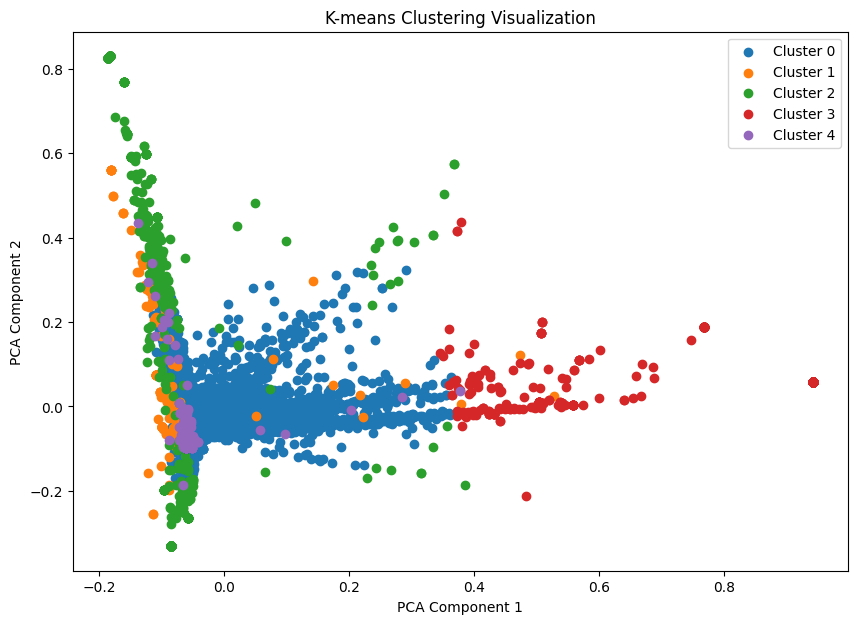

Clustered Data Sample:
                                                   Reviews  Cluster
262853  I needed a texting phone that did not require ...        0
70999                                          Excellent!        2
324745  I recommend this excellent team for the many d...        0
114637  updated review. Purchased this phone on Novemb...        0
221325                                       battery fail        0


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load the dataset
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")
csv_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)

if csv_file:
    df = pd.read_csv(csv_file)
else:
    print("CSV file not found.")
    exit()

# Keep only relevant columns
df = df[['Reviews']]  # Adjust column name if necessary
df = df.dropna()  # Drop missing values
print("Sample Reviews:\n", df.head())

# Step 1: Load Dataset
# (Insert dataset loading code here, sampling only 10,000 rows if necessary)
df = df.sample(n=10000, random_state=42)

# Step 2: Preprocess and Vectorize Reviews
# Convert reviews to lowercase and strip extra spaces
reviews = df['Reviews'].str.lower().str.strip()

# Use TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(reviews)

# Step 3: Apply K-means Clustering
optimal_k = 5  # Choose based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Add cluster labels to the original data
df['Cluster'] = kmeans.labels_

# Step 4: Visualize Clusters
# Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('K-means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Display clustered data
print("Clustered Data Sample:\n", df.head())

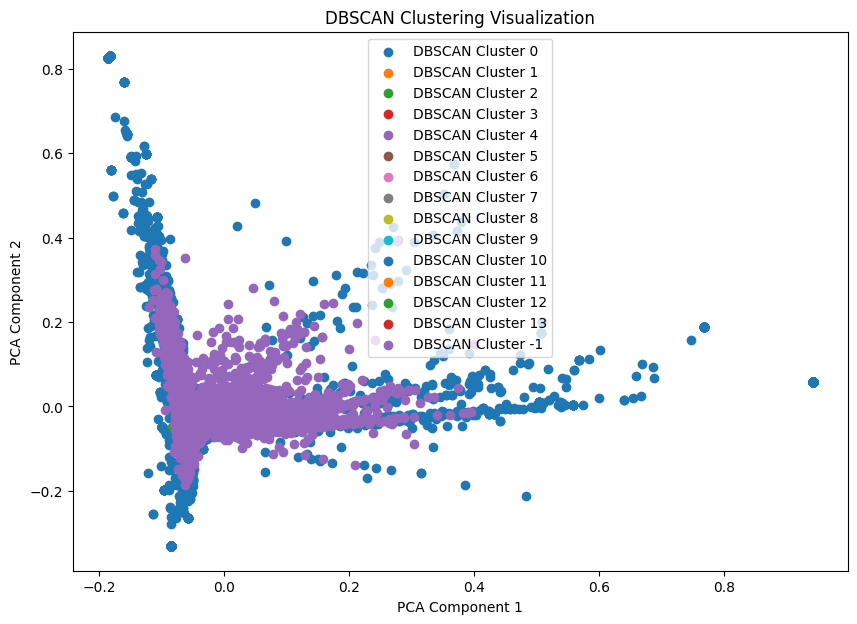

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine', n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X)
df['DBSCAN_Cluster'] = dbscan_labels

# Step : Visualize DBSCAN Clusters
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)
for cluster in unique_labels:
    cluster_points = X_reduced[np.array(dbscan_labels) == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'DBSCAN Cluster {cluster}')
plt.title('DBSCAN Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

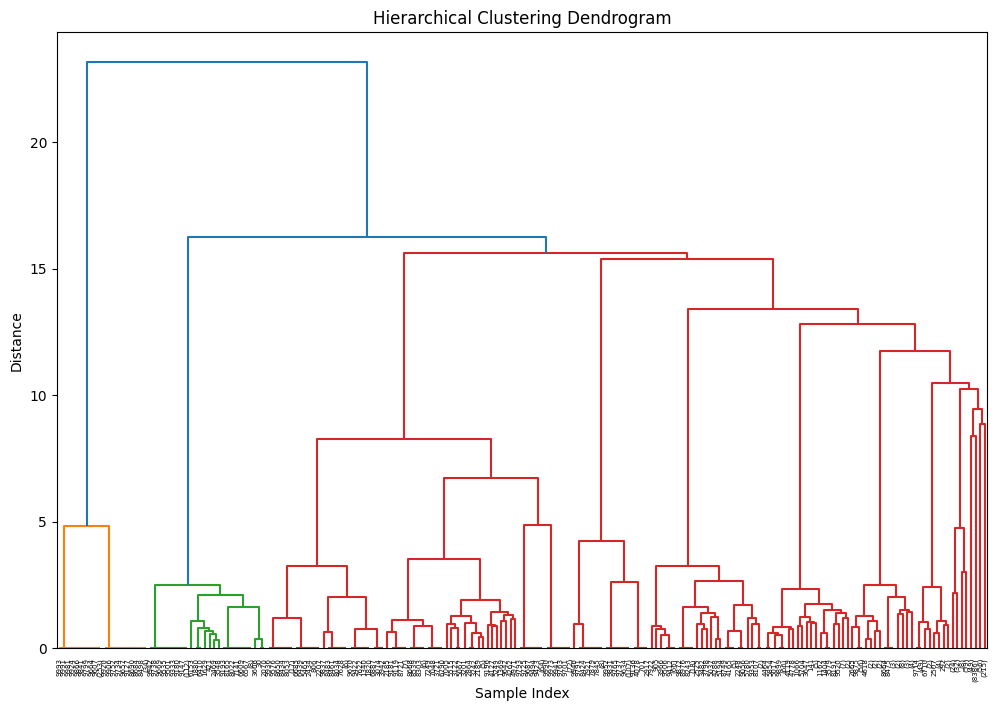

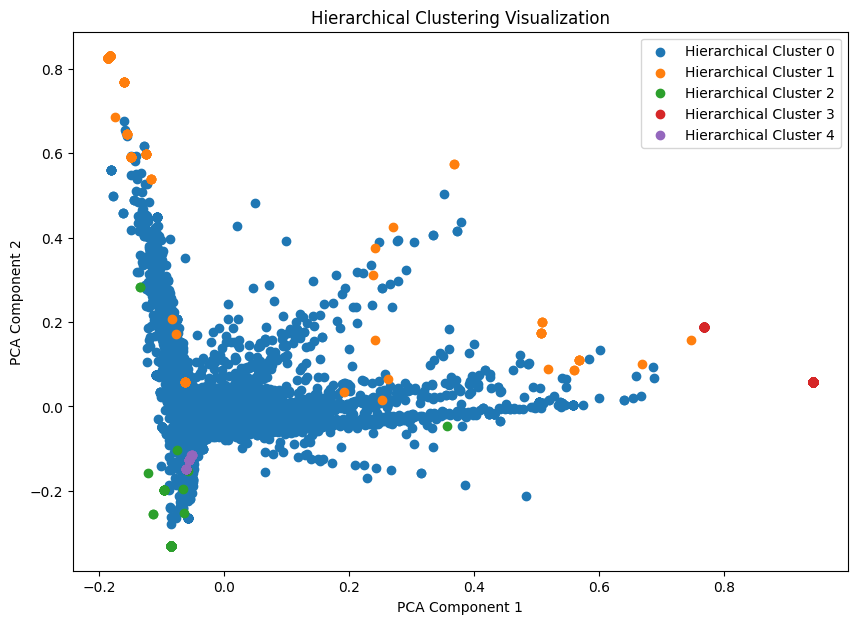


Hierarchical Clustered Data Sample:
                                                  Reviews  \
262853  I needed a texting phone that did not require ...   
70999                                          Excellent!   
324745  I recommend this excellent team for the many d...   
114637  updated review. Purchased this phone on Novemb...   
221325                                       battery fail   

        Hierarchical_Cluster  
262853                     0  
70999                      2  
324745                     0  
114637                     0  
221325                     0  


In [ ]:
# Step : Apply Hierarchical Clustering
# Using Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')

hierarchical_labels = hierarchical.fit_predict(X.toarray())
df['Hierarchical_Cluster'] = hierarchical_labels

# Hierarchical Clustering Dendrogram


from scipy.cluster.hierarchy import dendrogram, linkage
linkage_matrix = linkage(X.toarray(), method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)  # Show only the top 10 levels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Hierarchical Clustering Visualization
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['Hierarchical_Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Hierarchical Cluster {cluster}')
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
print("\nHierarchical Clustered Data Sample:")
print(df[['Reviews', 'Hierarchical_Cluster']].head())

Sample Reviews:
                                              Reviews
0  I feel so LUCKY to have found this used (phone...
1  nice phone, nice up grade from my pantach revu...
2                                       Very pleased
3  It works good but it goes slow sometimes but i...
4  Great phone to replace my lost phone. The only...


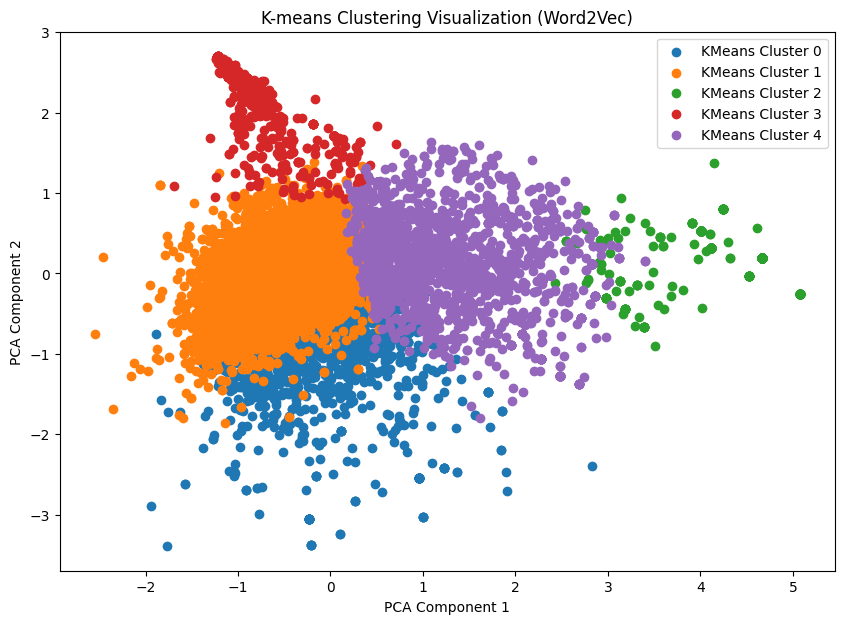

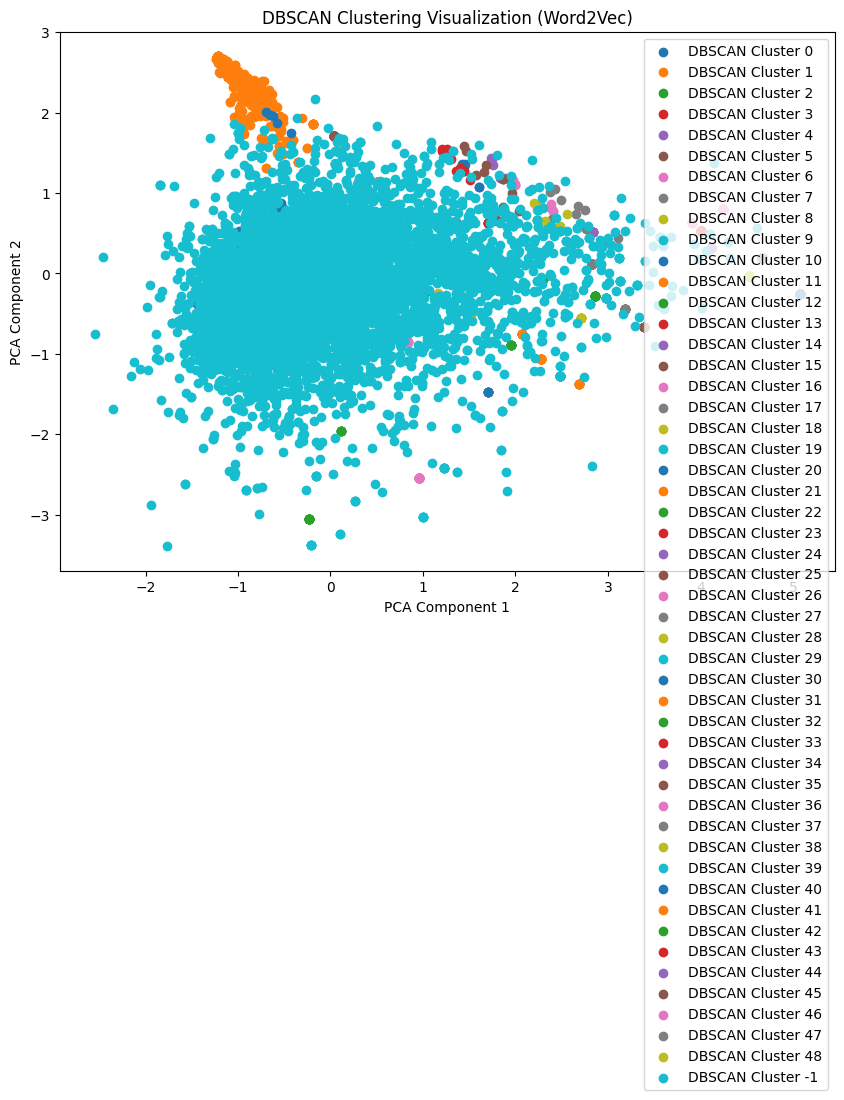

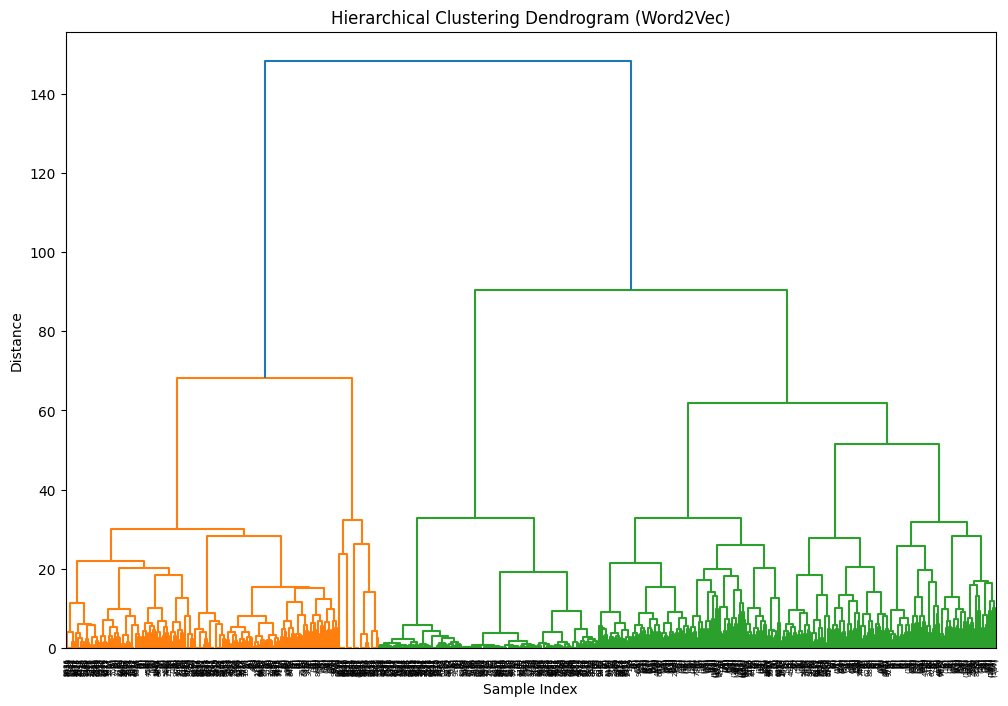

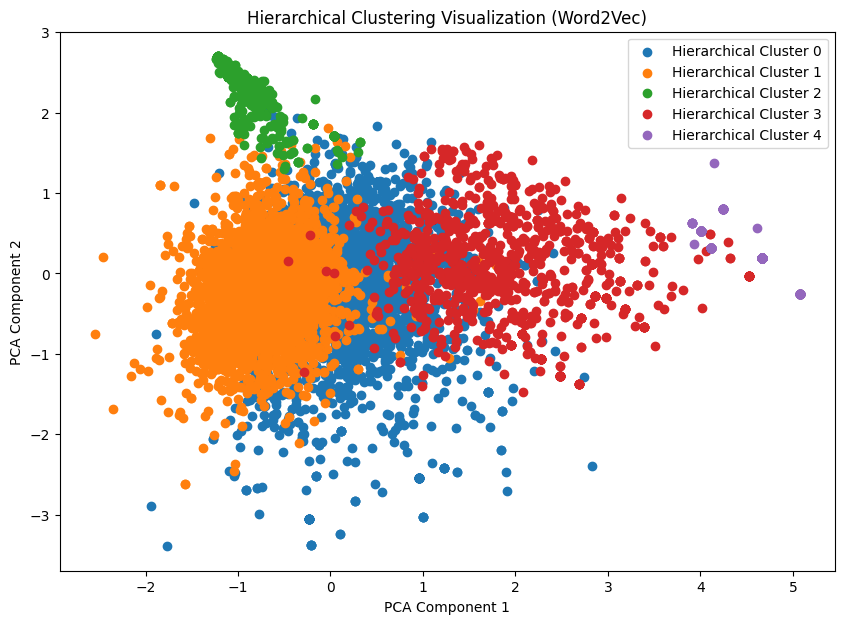


K-means Clustered Data Sample:
                                                  Reviews  KMeans_Cluster
262853  I needed a texting phone that did not require ...               1
70999                                          Excellent!               3
324745  I recommend this excellent team for the many d...               1
114637  updated review. Purchased this phone on Novemb...               1
221325                                       battery fail               1

DBSCAN Clustered Data Sample:
                                                  Reviews  DBSCAN_Cluster
262853  I needed a texting phone that did not require ...               0
70999                                          Excellent!               1
324745  I recommend this excellent team for the many d...              -1
114637  updated review. Purchased this phone on Novemb...              -1
221325                                       battery fail              -1

Hierarchical Clustered Data Sample:
            

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Step 1: Load the dataset
import kagglehub
import os

# Download the dataset
path = kagglehub.dataset_download("PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")
csv_file = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_file = os.path.join(root, file)

if csv_file:
    df = pd.read_csv(csv_file)
else:
    print("CSV file not found.")
    exit()

# Keep only relevant columns
df = df[['Reviews']]  # Adjust column name if necessary
df = df.dropna()  # Drop missing values
print("Sample Reviews:\n", df.head())

# (Insert dataset loading code here, sampling only 10,000 rows if necessary)
df = df.sample(n=10000, random_state=42)

# Step 2: Preprocess Text Data
reviews = df['Reviews'].str.lower().str.strip()

# Tokenize reviews into lists of words
reviews_tokens = reviews.str.split()

# Step 3: Train Word2Vec Model
# Train a Word2Vec model on the tokenized reviews
word2vec_model = Word2Vec(sentences=reviews_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=0)

# Step 4: Get Sentence Vectors
# Average the Word2Vec word vectors for each sentence to get sentence vectors
def get_sentence_vector(sentence, model):
    words = [word for word in sentence if word in model.wv]
    if len(words) > 0:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

sentence_vectors = np.array([get_sentence_vector(tokens, word2vec_model) for tokens in reviews_tokens])

# Step 5: Apply K-means Clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(sentence_vectors)
df['KMeans_Cluster'] = kmeans.labels_

# Step 6: Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_labels = dbscan.fit_predict(sentence_vectors)
df['DBSCAN_Cluster'] = dbscan_labels

# Step 7: Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(sentence_vectors)
df['Hierarchical_Cluster'] = hierarchical_labels

# Step 8: Visualizations

# K-means Visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(sentence_vectors)

plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['KMeans_Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'KMeans Cluster {cluster}')
plt.title('K-means Clustering Visualization (Word2Vec)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# DBSCAN Visualization
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)
for cluster in unique_labels:
    cluster_points = X_reduced[np.array(dbscan_labels) == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'DBSCAN Cluster {cluster}')
plt.title('DBSCAN Clustering Visualization (Word2Vec)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Hierarchical Clustering Dendrogram
linkage_matrix = linkage(sentence_vectors, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (Word2Vec)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Hierarchical Clustering Visualization
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['Hierarchical_Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Hierarchical Cluster {cluster}')
plt.title('Hierarchical Clustering Visualization (Word2Vec)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Step 9: Display Clustered Data Samples
print("\nK-means Clustered Data Sample:")
print(df[['Reviews', 'KMeans_Cluster']].head())

print("\nDBSCAN Clustered Data Sample:")
print(df[['Reviews', 'DBSCAN_Cluster']].head())

print("\nHierarchical Clustered Data Sample:")
print(df[['Reviews', 'Hierarchical_Cluster']].head())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

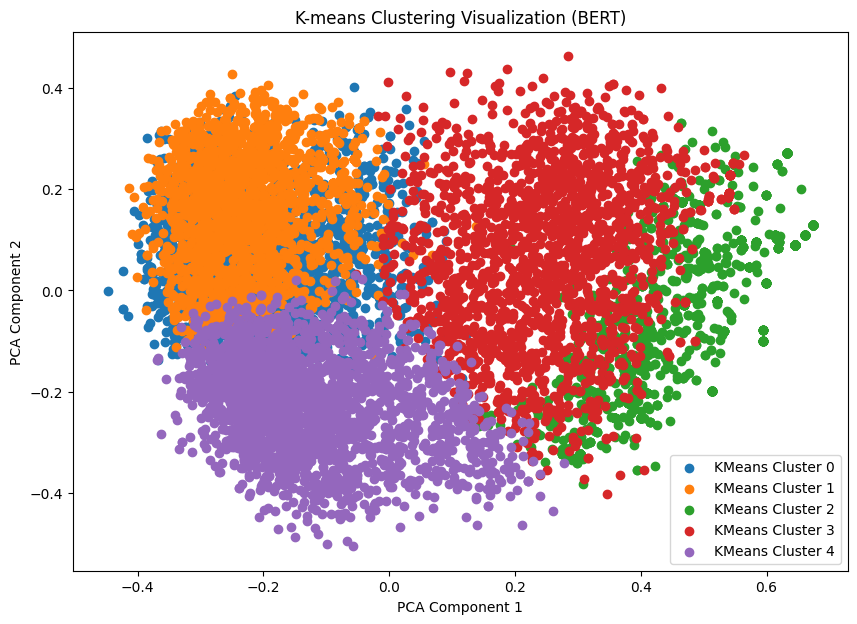

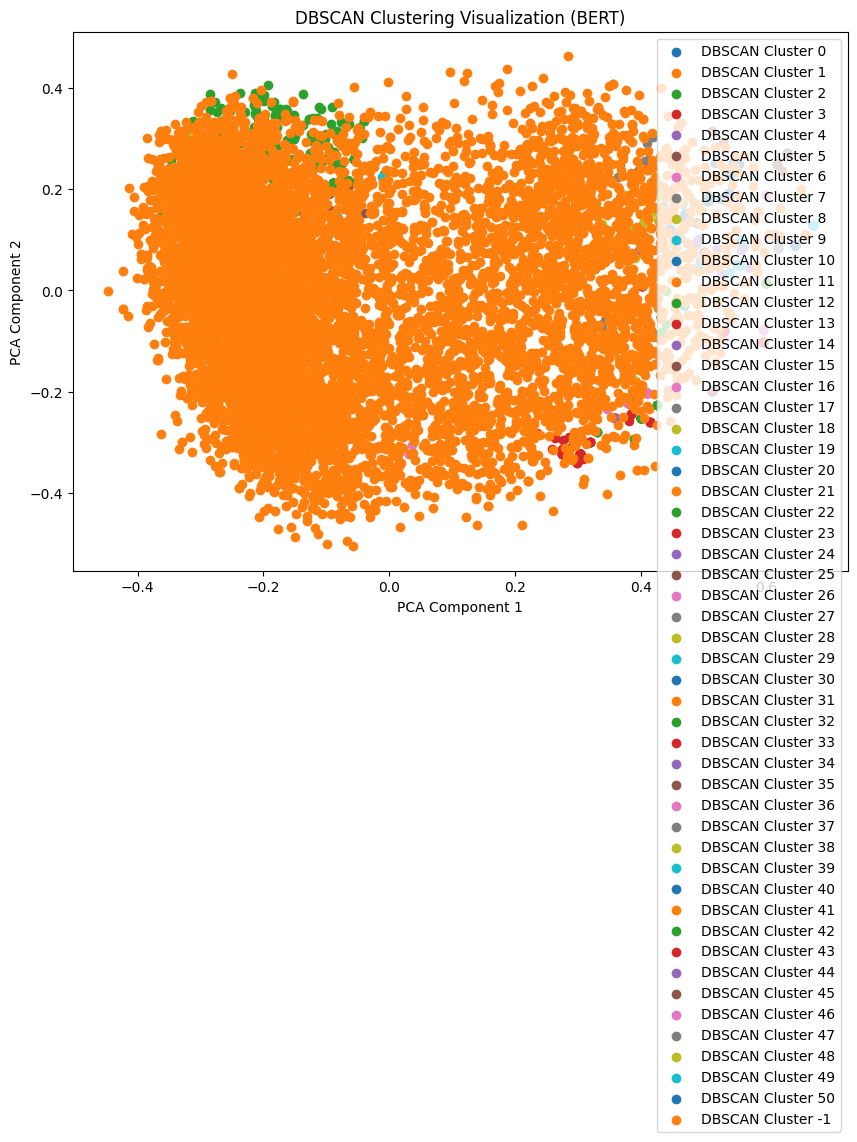

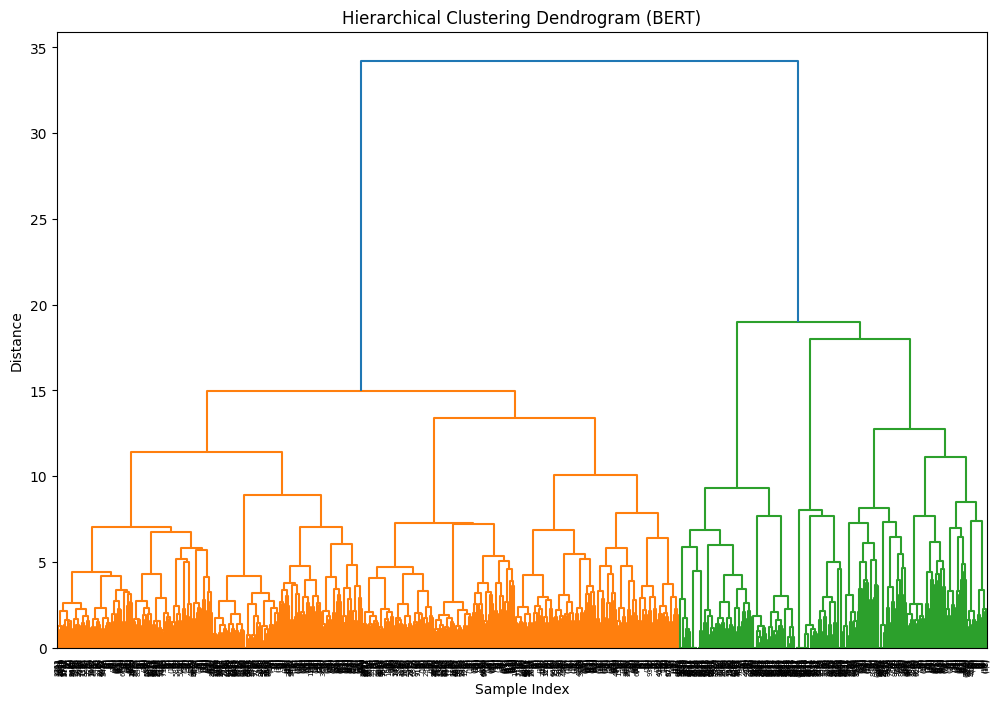

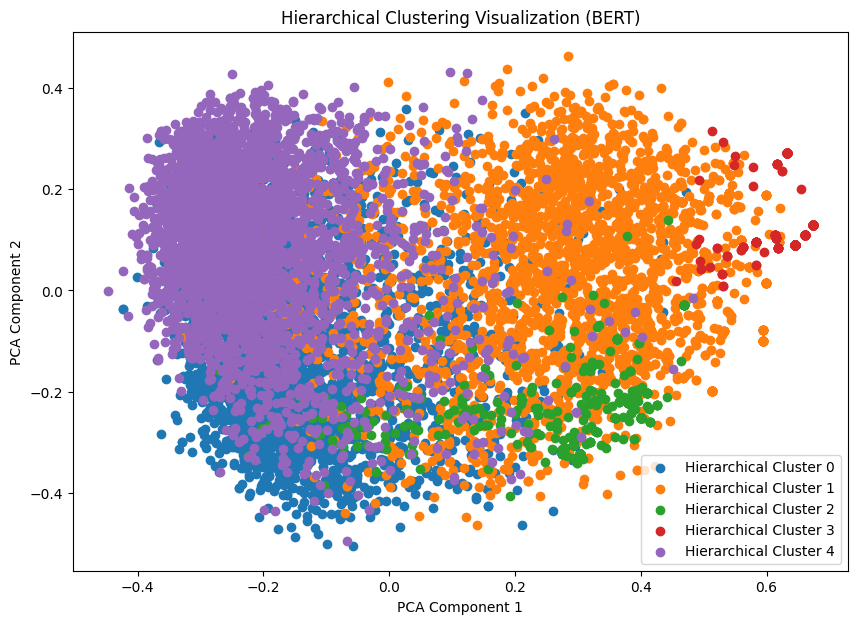


K-means Clustered Data Sample:
                                                  Reviews  KMeans_Cluster
114286  It broke 5 days after I purchased it. The ear ...               4
41427                                            Terrible               2
4210    It's a generation 1 iPhone 6, with the weaker ...               0
316290  Good phone. Features are just right. Processor...               1
287270                                      Great product               3

DBSCAN Clustered Data Sample:
                                                  Reviews  DBSCAN_Cluster
114286  It broke 5 days after I purchased it. The ear ...              -1
41427                                            Terrible              -1
4210    It's a generation 1 iPhone 6, with the weaker ...              -1
316290  Good phone. Features are just right. Processor...              -1
287270                                      Great product               0

Hierarchical Clustered Data Sample:
            

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Step 1: Load Dataset
# Assuming the dataset has already been loaded and preprocessed as df
df = df.sample(n=10000, random_state=42)  # Reduce size if needed

# Step 2: Preprocess Text Data
reviews = df['Reviews'].dropna().str.lower().str.strip()

# Step 3: Generate BERT Embeddings
# Load a pre-trained BERT model from SentenceTransformers
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast
sentence_embeddings = model.encode(reviews.to_list(), show_progress_bar=True)

# Step 4: Apply K-means Clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(sentence_embeddings)
df['KMeans_Cluster'] = kmeans_labels

# Step 5: Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
dbscan_labels = dbscan.fit_predict(sentence_embeddings)
df['DBSCAN_Cluster'] = dbscan_labels

# Step 6: Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(sentence_embeddings)
df['Hierarchical_Cluster'] = hierarchical_labels

# Step 7: Visualizations

# Reduce dimensionality for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(sentence_embeddings)

# K-means Visualization
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['KMeans_Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'KMeans Cluster {cluster}')
plt.title('K-means Clustering Visualization (BERT)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# DBSCAN Visualization
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)
for cluster in unique_labels:
    cluster_points = X_reduced[np.array(dbscan_labels) == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'DBSCAN Cluster {cluster}')
plt.title('DBSCAN Clustering Visualization (BERT)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Hierarchical Clustering Dendrogram
linkage_matrix = linkage(sentence_embeddings, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram (BERT)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Hierarchical Clustering Visualization
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    cluster_points = X_reduced[df['Hierarchical_Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Hierarchical Cluster {cluster}')
plt.title('Hierarchical Clustering Visualization (BERT)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Step 8: Display Clustered Data Samples
print("\nK-means Clustered Data Sample:")
print(df[['Reviews', 'KMeans_Cluster']].head())

print("\nDBSCAN Clustered Data Sample:")
print(df[['Reviews', 'DBSCAN_Cluster']].head())

print("\nHierarchical Clustered Data Sample:")
print(df[['Reviews', 'Hierarchical_Cluster']].head())

**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.


**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:





'''